In [1]:
import sys

sys.path.append("../scripts")

import pandas as pd

from load import load_config, read_config_data
from preprocess import preprocess_profiles
from plot_utils import plot_unique_value_hist

### Read profiles and make a subset with overlapping plates

See https://github.com/jump-cellpainting/jump-cellpainting/issues/78#issuecomment-805942281

In [2]:
subset_cfg = load_config("../configs/subset/overlap_orfs.yaml")
subset_ann_df = read_config_data(subset_cfg["overlap_orfs"])
subset_ann_df

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,48.712002,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,61.765999,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,42.872002,40.491001,40.872002,40.462002,40.923000,41.264000,42.422001,41.236000,42.514000,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,51.533001,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,55.993000,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,31.225000,28.951000,29.181999,29.153999,29.162001,29.171000,30.061001,29.388000,29.938000,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,34.605999,32.294998,32.636002,32.362000,32.466000,32.683998,33.604000,32.743999,33.476002,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,30.981001,28.872999,29.042000,28.905001,29.143999,29.282000,30.084999,29.292000,30.077000,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,33.861000,31.473000,31.583000,31.374001,31.563999,31.844000,32.480000,31.665001,32.480999,2021_05_17_Batch4


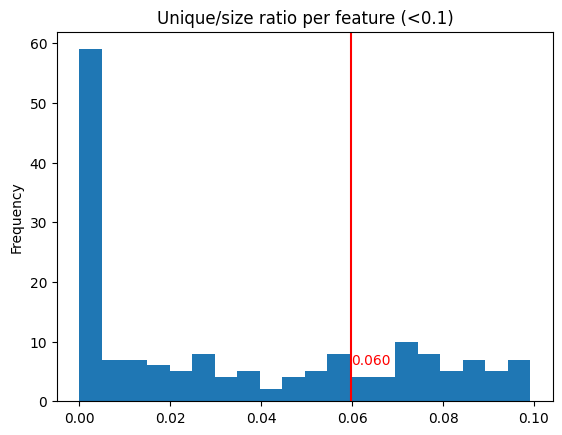

In [3]:
plot_unique_value_hist(subset_ann_df, features="Cells_Count")

### Save subset profiles

In [4]:
subset_ann_df.to_parquet("output/subset_profiles.parquet", index=False)

## Preprocess subset features

In [5]:
preprocess_config = load_config("../configs/preprocess")
preprocess_config

{'normalize_group': 'Metadata_Plate',
 'normalize_kwargs': {'method': 'mad_robustize',
  'mad_robustize_epsilon': 0.0,
  'image_features': True},
 'feature_select_whitelist': ['Cells_Count'],
 'feature_select_kwargs': {'operation': ['variance_threshold',
   'correlation_threshold',
   'drop_na_columns',
   'blocklist'],
  'unique_cut': 0.01,
  'image_features': True}}

In [6]:
%%time
subset_ann_df = preprocess_profiles(subset_ann_df, **preprocess_config)
subset_ann_df.shape

CPU times: user 11min 56s, sys: 5.06 s, total: 12min 1s
Wall time: 12min 9s


(19143, 842)

#### Check that feature medians are close to 0

In [7]:
subset_ann_df.reset_index(drop=True, inplace=True)
subset_ann_df.groupby("Metadata_Plate").median(numeric_only=True).filter(
    regex="^(?!Metadata_)"
).max().sort_values(ascending=False)

Nuclei_Correlation_Overlap_ER_RNA                4.963505e-05
Nuclei_AreaShape_Solidity                        2.644854e-05
Cells_Texture_InfoMeas2_ER_3_00_256              2.627647e-05
Nuclei_Correlation_Overlap_AGP_ER                2.497097e-05
Nuclei_Correlation_Overlap_DNA_RNA               2.196824e-05
                                                     ...     
Image_ImageQuality_LocalFocusScore_OrigDNA_50    4.431157e-08
Nuclei_AreaShape_Orientation                     2.785243e-08
Cytoplasm_AreaShape_Orientation                  7.223931e-09
Cells_Correlation_Manders_DNA_RNA                0.000000e+00
Cells_Count                                      0.000000e+00
Length: 825, dtype: float64

### Save processed subset profiles

In [8]:
subset_ann_df.to_parquet("output/subset_processed_profiles.parquet", index=False)
subset_ann_df

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_02_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Nuclei_Texture_SumVariance_DNA_3_02_256,Nuclei_Texture_SumVariance_ER_10_03_256,Cells_Count
0,JCP2022_900008,ccsbBroad304_00010,ORF011294.1_TRC304.1,pLX_304,NM_001278352.1,ACO1,48,9606,aconitase 1,100.0,...,-1.630447,0.320777,-1.428334,-0.046419,1.271371,-0.208324,0.202360,-0.044861,1.367060,1.016925
1,JCP2022_900034,ccsbBroad304_00038,ORF001874.1_TRC304.1,pLX_304,NM_000643.2,AGL,178,9606,"amylo-alpha-1, 6-glucosidase, 4-alpha-glucanot...",100.0,...,-1.713351,-0.090217,-1.458614,0.120309,1.279027,0.650121,0.918840,-1.644120,0.823474,1.577271
2,JCP2022_900327,ccsbBroad304_00356,ORF005713.1_TRC304.1,pLX_304,NM_001304.5,CPD,1362,9606,carboxypeptidase D,100.0,...,-0.825970,-0.270656,-1.012781,1.297825,0.836286,0.252346,0.643505,0.677639,0.375317,-0.352811
3,JCP2022_900417,ccsbBroad304_00448,ORF010275.1_TRC304.1,pLX_304,NM_021120.4,DLG3,1741,9606,discs large MAGUK scaffold protein 3,100.0,...,0.986662,-0.681650,-0.306966,1.863373,-0.466784,2.045490,-1.688061,-2.013634,-1.290032,-0.290550
4,JCP2022_900443,ccsbBroad304_00474,ORF014835.1_TRC304.1,pLX_304,NM_001258316.1,ECT2,1894,9606,epithelial cell transforming 2,100.0,...,-0.172973,-0.744660,0.122160,1.553597,-0.090734,0.735807,0.096500,0.539514,-0.416065,-0.477332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-0.553293,0.229975,-0.506501,0.138817,0.536639,-0.447200,0.750188,-0.106818,0.762016,0.208088
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.866828,1.257922,0.440656,-0.330972,-0.730616,-0.157921,-0.383947,0.371311,-0.588184,1.270052
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,1.806110,0.192932,1.315214,-1.499569,-1.646347,-0.357171,-1.256609,-0.274468,-1.299471,1.076315
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.538802,-0.879772,-0.753843,0.676057,0.616393,-0.898091,-0.657668,0.375204,-0.104637,-1.191122
